In [1]:
import numpy as np
import pandas as pd

import pyopentd as pt

# 解析実行

In [2]:
# TDモデルの読み込み
dwg_path = "./td_model/sample.dwg"
td = pt.ThermalDesktop(dwg_path)

In [3]:
# ケースセットの一覧確認
casesets = td.get_casesets()
casesets.head()

,group_name,caseset_name
0,chamber,Case Set 0
1,chamber,steady
2,chamber,No rad
3,orbit,Case Set 2


In [4]:
# ケースセットの読み込み
# orbit.Case Set 2 以外は動かないので注意。
group_name = 'orbit'
caseset_name = 'Case Set 2'
case = td.get_caseset(caseset_name, group_name)

In [5]:
# 軌道情報の取得
orbit_name = case.get_orbit_name()
print(orbit_name)
df_orbit = td.get_orbit(orbit_name)
df_orbit.head()

sample_orbit


,Times,sun_x,sun_y,sun_z,planet_x,planet_y,planet_z,radius
0,0.000000,0.0,0.0,1.0,0.0,-1.066924e-13,-1.000000e+00,1.078393
1,473.081495,0.0,0.0,1.0,0.0,5.000000e-01,-8.660254e-01,1.078393
2,946.162989,0.0,0.0,1.0,0.0,8.660254e-01,-5.000000e-01,1.078393
3,1419.244484,0.0,0.0,1.0,0.0,1.000000e+00,-1.331770e-13,1.078393
4,1765.927780,0.0,0.0,1.0,0.0,9.272846e-01,3.743571e-01,1.078393


In [6]:
# 実行
case.run()

# 結果出力

In [7]:
sav_name = case.origin.SindaOptions.SaveFilename
print(sav_name)

case2.sav


In [8]:
sav_path = f'./td_model/{case.origin.UserDirectory}/{sav_name}'
sav_path

'./td_model/output/case2.sav'

In [9]:
savefile = pt.SaveFile(sav_path)

In [10]:
df_temp = savefile.get_all_temperature().drop('Times', axis=1)
df_heat = savefile.get_all_heatrate().drop('Times', axis=1)

In [11]:
def get_attitude(t_list, df):
    attitude_list = []
    for t in t_list:
        attitude = np.zeros(6)
        T_orbit = df.iloc[-1]['Times']
        dt = df.iloc[-1]['Times'] - df.iloc[-2]['Times']
        t = t % T_orbit
        t_bef_index = t // dt
        t_af_index = t_bef_index + 1
        
        attitude_bef = df.iloc[int(t_bef_index)].values
        attitude_af = df.iloc[int(t_af_index)].values
        
        rate = (t % dt) / dt
        attitude = (1-rate)*attitude_bef + rate*attitude_af
        
        attitude_list.append(attitude[1:])
    
    return pd.DataFrame(attitude_list, columns=df.columns[1:])

In [12]:
df_orbit_modify = get_attitude(savefile.times, df_orbit)
# df_orbit_modify
df_time = pd.DataFrame(savefile.times, columns=['Times'])
df_case = pd.DataFrame([f'{case.origin.GroupName}.{case.origin.Name}']*len(savefile.times), columns=['case'])

In [13]:
df = pd.concat([df_case, df_time, df_orbit_modify, df_temp, df_heat], axis=1)
df.to_csv('sample_output.csv', index=False)

In [14]:
df.head(10)

,case,Times,sun_x,sun_y,sun_z,planet_x,planet_y,planet_z,radius,CHAMBER.T1,...,PANEL_PZ.Q1,PANEL_PZ.Q2,PANEL_PZ.Q3,PANEL_PZ.Q4,PANEL_PZ.Q5,PANEL_PZ.Q6,PANEL_PZ.Q7,PANEL_PZ.Q8,PANEL_PZ.Q9,SPACE.Q1
0,orbit.Case Set 2,0.0,0.0,0.0,1.0,0.0,-1.066924e-13,-1.000000,1.078393,20.0,...,2.456174,2.471695,2.468606,2.447469,2.435818,2.454345,2.470335,2.454078,2.453937,-32.776808
1,orbit.Case Set 2,120.0,0.0,0.0,1.0,0.0,1.268280e-01,-0.966017,1.078393,20.0,...,2.455652,2.472089,2.470132,2.447113,2.436130,2.455766,2.469993,2.454330,2.455753,-33.298115
2,orbit.Case Set 2,240.0,0.0,0.0,1.0,0.0,2.536561e-01,-0.932033,1.078393,20.0,...,2.455127,2.472485,2.471667,2.446755,2.436444,2.457196,2.469649,2.454584,2.457579,-33.783538
3,orbit.Case Set 2,360.0,0.0,0.0,1.0,0.0,3.804841e-01,-0.898050,1.078393,20.0,...,2.454587,2.472892,2.473246,2.446387,2.436767,2.458667,2.469296,2.454845,2.459459,-34.230013
4,orbit.Case Set 2,480.0,0.0,0.0,1.0,0.0,5.053529e-01,-0.860673,1.078393,20.0,...,2.454309,2.473519,2.475016,2.446259,2.437312,2.460331,2.469165,2.455328,2.461493,-34.640513
5,orbit.Case Set 2,600.0,0.0,0.0,1.0,0.0,5.981975e-01,-0.767828,1.078393,20.0,...,2.464402,2.483250,2.485366,2.455725,2.447015,2.470590,2.477916,2.464979,2.470812,-35.011364
6,orbit.Case Set 2,720.0,0.0,0.0,1.0,0.0,6.910420e-01,-0.674983,1.078393,20.0,...,2.474472,2.492958,2.495692,2.465169,2.456695,2.480825,2.486647,2.474607,2.480110,-35.339570
7,orbit.Case Set 2,840.0,0.0,0.0,1.0,0.0,7.838866e-01,-0.582139,1.078393,20.0,...,2.484557,2.502681,2.506033,2.474627,2.466390,2.491075,2.495391,2.484249,2.489421,-35.626852
8,orbit.Case Set 2,960.0,0.0,0.0,1.0,0.0,8.699440e-01,-0.485376,1.078393,20.0,...,2.494782,2.512669,2.516431,2.484394,2.476426,2.501480,2.504486,2.494247,2.499080,-35.874867
9,orbit.Case Set 2,1080.0,0.0,0.0,1.0,0.0,9.039275e-01,-0.358548,1.078393,20.0,...,2.506687,2.525720,2.527580,2.497716,2.490373,2.513714,2.517578,2.508321,2.512721,-36.082117


<AxesSubplot:xlabel='Times'>

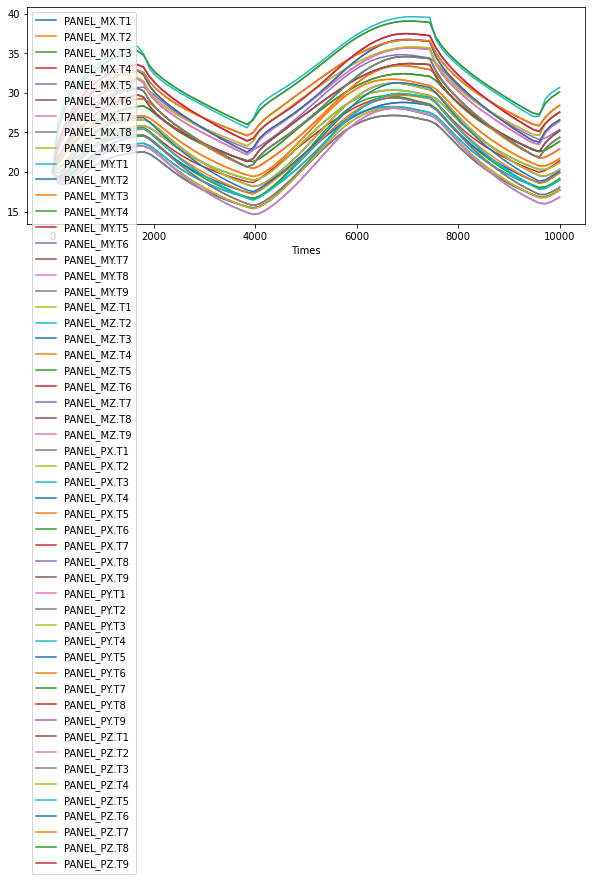

In [15]:
t_list = [s for s in df.columns if '.T' in s]
t_list = [s for s in t_list if not 'CHAMBER' in s]
t_list.remove('SPACE.T1')
df[['Times']+t_list].plot(x='Times', figsize=(10,4))